## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Jun  7 06:19:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install

In [ ]:
!pip install -q supervision ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 55.5 MB/s eta 0:00:00


## Imports

In [ ]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

## Download Data

**NOTE:** In this notebook we will use one of the Supervision Assets videos. [Here](https://supervision.roboflow.com/assets) you can learn more about it.

In [ ]:
#download_assets(VideoAssets.VEHICLES)

## Configuration

In [ ]:
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Vechile Speed Detection System/Data/video1.mp4"
TARGET_VIDEO_PATH = "/content/drive/MyDrive/Vechile Speed Detection System/Data/Results/vehicles-result1.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8x.pt"
MODEL_RESOLUTION = 1280

In [ ]:
SOURCE = np.array([
    [740, 570],  #a
    [1120, 570], #b
    [1750,1080], #c              video1
    [0, 1080]  #d
])

TARGET_WIDTH = 25
TARGET_HEIGHT = 70

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

In [ ]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.


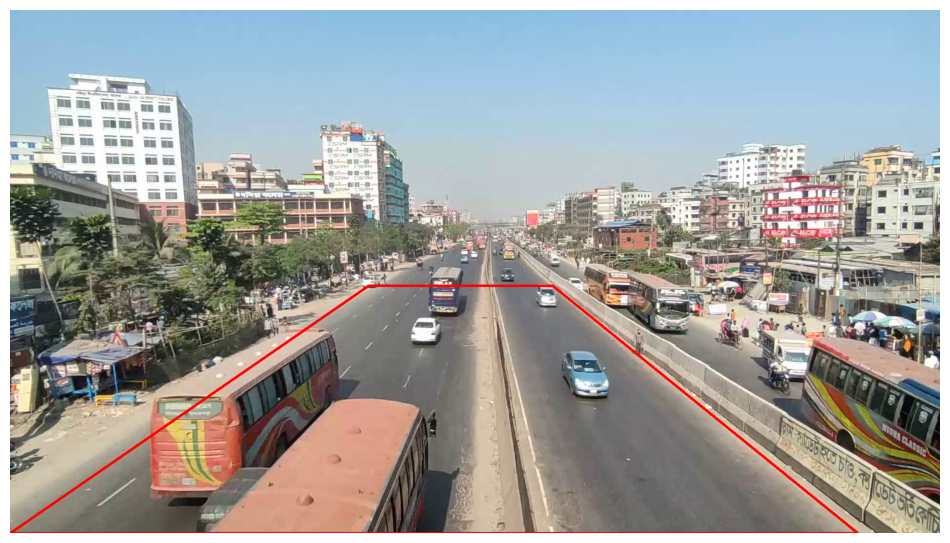

In [ ]:
annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.red(), thickness=4)
sv.plot_image(annotated_frame)

## Transform Perspective

In [ ]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [ ]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

## Process Video

In [ ]:
#import supervision
#l = [dir(supervision)]
#l

In [ ]:
import supervision
help(supervision)


Help on package supervision:

NAME
    supervision

PACKAGE CONTENTS
    annotators (package)
    assets (package)
    classification (package)
    config
    dataset (package)
    detection (package)
    draw (package)
    geometry (package)
    keypoint (package)
    metrics (package)
    tracker (package)
    utils (package)
    validators (package)

VERSION
    0.21.0

FILE
    /usr/local/lib/python3.10/dist-packages/supervision/__init__.py




**NOTE:** In this tutorial we use Supervision Annotators. [Here](https://supervision.roboflow.com/annotators) you can learn more about it.

In [ ]:
model = YOLO(MODEL_NAME)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# tracer initiation
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_thresh=CONFIDENCE_THRESHOLD
)

# annotators configuration
thickness = sv.calculate_optimal_line_thickness(
    resolution_wh=video_info.resolution_wh
)
text_scale = sv.calculate_optimal_text_scale(
    resolution_wh=video_info.resolution_wh
)
bounding_box_annotator = sv.BoundingBoxAnnotator(
    thickness=thickness
)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# open target video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    # loop over source video frame
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # filter out detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]

        # refine detections using non-max suppression
        detections = detections.with_nms(IOU_THRESHOLD)

        # pass detection through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(
            anchor=sv.Position.BOTTOM_CENTER
        )

        # calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # format labels
        labels = []

        for tracker_id in detections.tracker_id:
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"#{tracker_id}")
            else:
                # calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6
                labels.append(f"#{tracker_id} {int(speed)} km/h")

        # annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )

        # add frame to target video
        sink.write_frame(annotated_frame)

100%|██████████| 131M/131M [00:00<00:00, 398MB/s]
SupervisionWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'track_activation_threshold' instead.
SupervisionWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version supervision-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.
100%|██████████| 2223/2223 [06:39<00:00,  5.57it/s]
